<a href="https://colab.research.google.com/github/Oleksy1121/Car-damage-detection/blob/main/training/YOLOv8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-python~=4.10.0.84 pillow~=10.4.0 tkinterdnd2~=0.4.2 ultralytics~=8.2.95 -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.7/492.7 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.1/875.1 kB 44.6 MB/s eta 0:00:00


In [ ]:
# Install neccesary libraries
!pip install ultralytics --quiet

In [ ]:
# Import the YOLO library and other necessary libraries
from ultralytics import YOLO
import os
from IPython.display import display, Image
import yaml
import cv2
import matplotlib.pyplot as plt
import random
import matplotlib.patches as patches
from PIL import Image as PILImage
import cv2
import glob
import numpy as np

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
# Download the dataset and unzip it
!curl -L "https://app.roboflow.com/ds/t6xM6xE9bF?key=ym8EYKP9vQ" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

In [ ]:
# Path to the data YAML file
data_yaml = "/content/data.yaml"

# Open and read data from the YAML file
with open(data_yaml, 'r') as file:
    data = yaml.safe_load(file)

# Modify values for train, validation, and test datasets
data['train'] = "/content/train/images"
data['val'] = "/content/valid/images"
data['test'] = "/content/test/images"

# Save the modified data back to the YAML file
with open(data_yaml, 'w') as file:
    yaml.dump(data, file)

In [ ]:
# Load and visualize annotations

def load_class_names_and_colors(yaml_path):
    # Load class names and define colors for each class from a YAML file
    with open(yaml_path, 'r') as file:
        data = yaml.safe_load(file)
    names = data['names']
    colors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'aqua', 'grey']  # Define colors for classes
    return names, dict(zip(names, colors))

def display_images_with_annotations(image_folder_path, num_images=8, yaml_path=data_yaml):
    # Display images with annotations
    class_names, class_colors = load_class_names_and_colors(yaml_path)
    annotations_folder_path = image_folder_path.replace('/images', '/labels')
    image_files = [f for f in os.listdir(image_folder_path) if f.endswith('.jpg')]

    # Check if there are enough images to display
    if len(image_files) < num_images:
        print("Not enough images available.")
        num_images = len(image_files)
        if num_images == 0:
            print("No images to display.")
            return  # Exit function if no images are available

    random.shuffle(image_files)

    fig, axs = plt.subplots(1, num_images, figsize=(5 * num_images, 5))
    for i, file in enumerate(image_files[:num_images]):
        img_path = os.path.join(image_folder_path, file)
        ann_path = os.path.join(annotations_folder_path, file.replace('.jpg', '.txt'))
        img = PILImage.open(img_path)
        axs[i].imshow(img)
        axs[i].axis('off')

        draw_annotations(axs[i], ann_path, img.size, class_names, class_colors)

    plt.show()

def draw_annotations(ax, annotation_path, image_size, class_names, class_colors):
    # Draw annotations on an image
    with open(annotation_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            class_id = int(parts[0])
            class_name = class_names[class_id]
            color = class_colors[class_name]
            if len(parts) == 5:  # YOLO bounding boxes
                draw_yolo_bbox(ax, parts, image_size, class_name, color)
            else:  # Polygon coordinates
                draw_polygon(ax, parts, image_size, class_name, color)

def draw_yolo_bbox(ax, parts, image_size, class_name, color):
    # Draw YOLO format bounding box
    x_center = float(parts[1]) * image_size[0]
    y_center = float(parts[2]) * image_size[1]
    width = float(parts[3]) * image_size[0]
    height = float(parts[4]) * image_size[1]
    x_min = x_center - width / 2
    y_min = y_center - height / 2
    rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor=color, facecolor='none')
    ax.add_patch(rect)
    ax.text(x_min, y_min - 10, class_name, color='white', fontsize=12, backgroundcolor=color)

def draw_polygon(ax, parts, image_size, class_name, color):
    # Draw polygon annotation
    points = list(map(float, parts[1:]))
    polygon = [(points[i] * image_size[0], points[i + 1] * image_size[1]) for i in range(0, len(points), 2)]
    poly_shape = patches.Polygon(polygon, linewidth=2, edgecolor=color, facecolor='none')
    ax.add_patch(poly_shape)
    ax.text(polygon[0][0], polygon[0][1] - 10, class_name, color='white', fontsize=12, backgroundcolor=color)

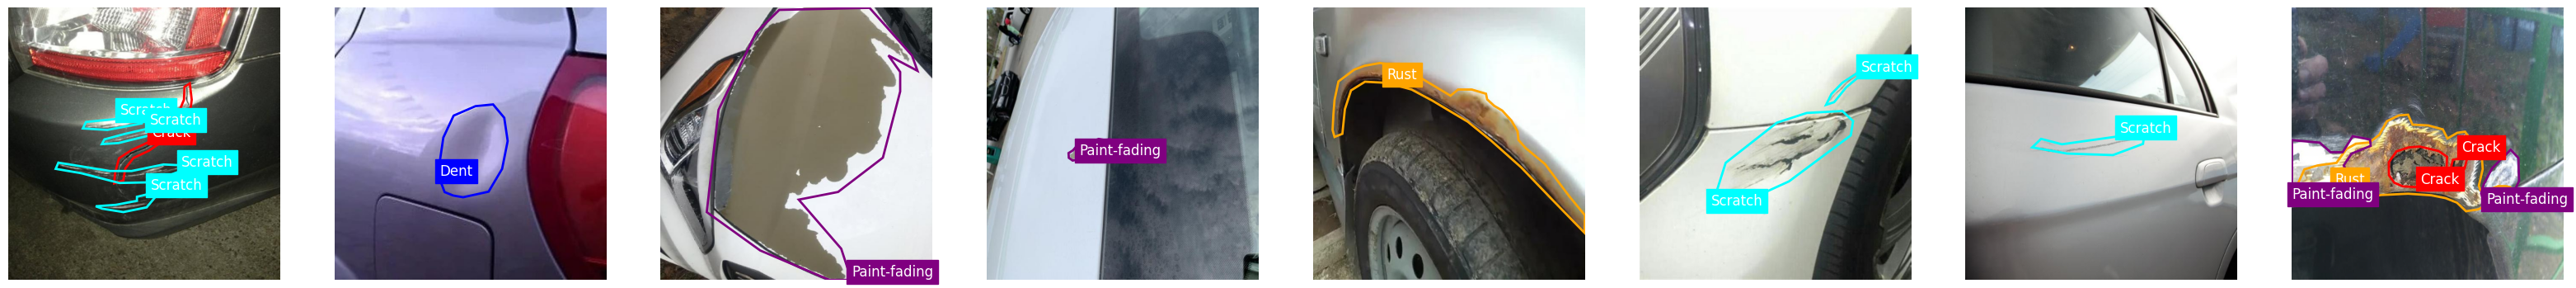

In [ ]:
# Example function call
display_images_with_annotations(data['train'])

In [ ]:
# Train the YOLOv8 model with specified parameters
!yolo task=detect mode=train model=yolov8m.pt data="/content/data.yaml" epochs = 100 imgsz = 640 batch = -1

Wyniki trenowania modelu

In [ ]:
# Display training results image
display(Image(filename='/content/runs/detect/train/results.png'))

Macierz pomyłek

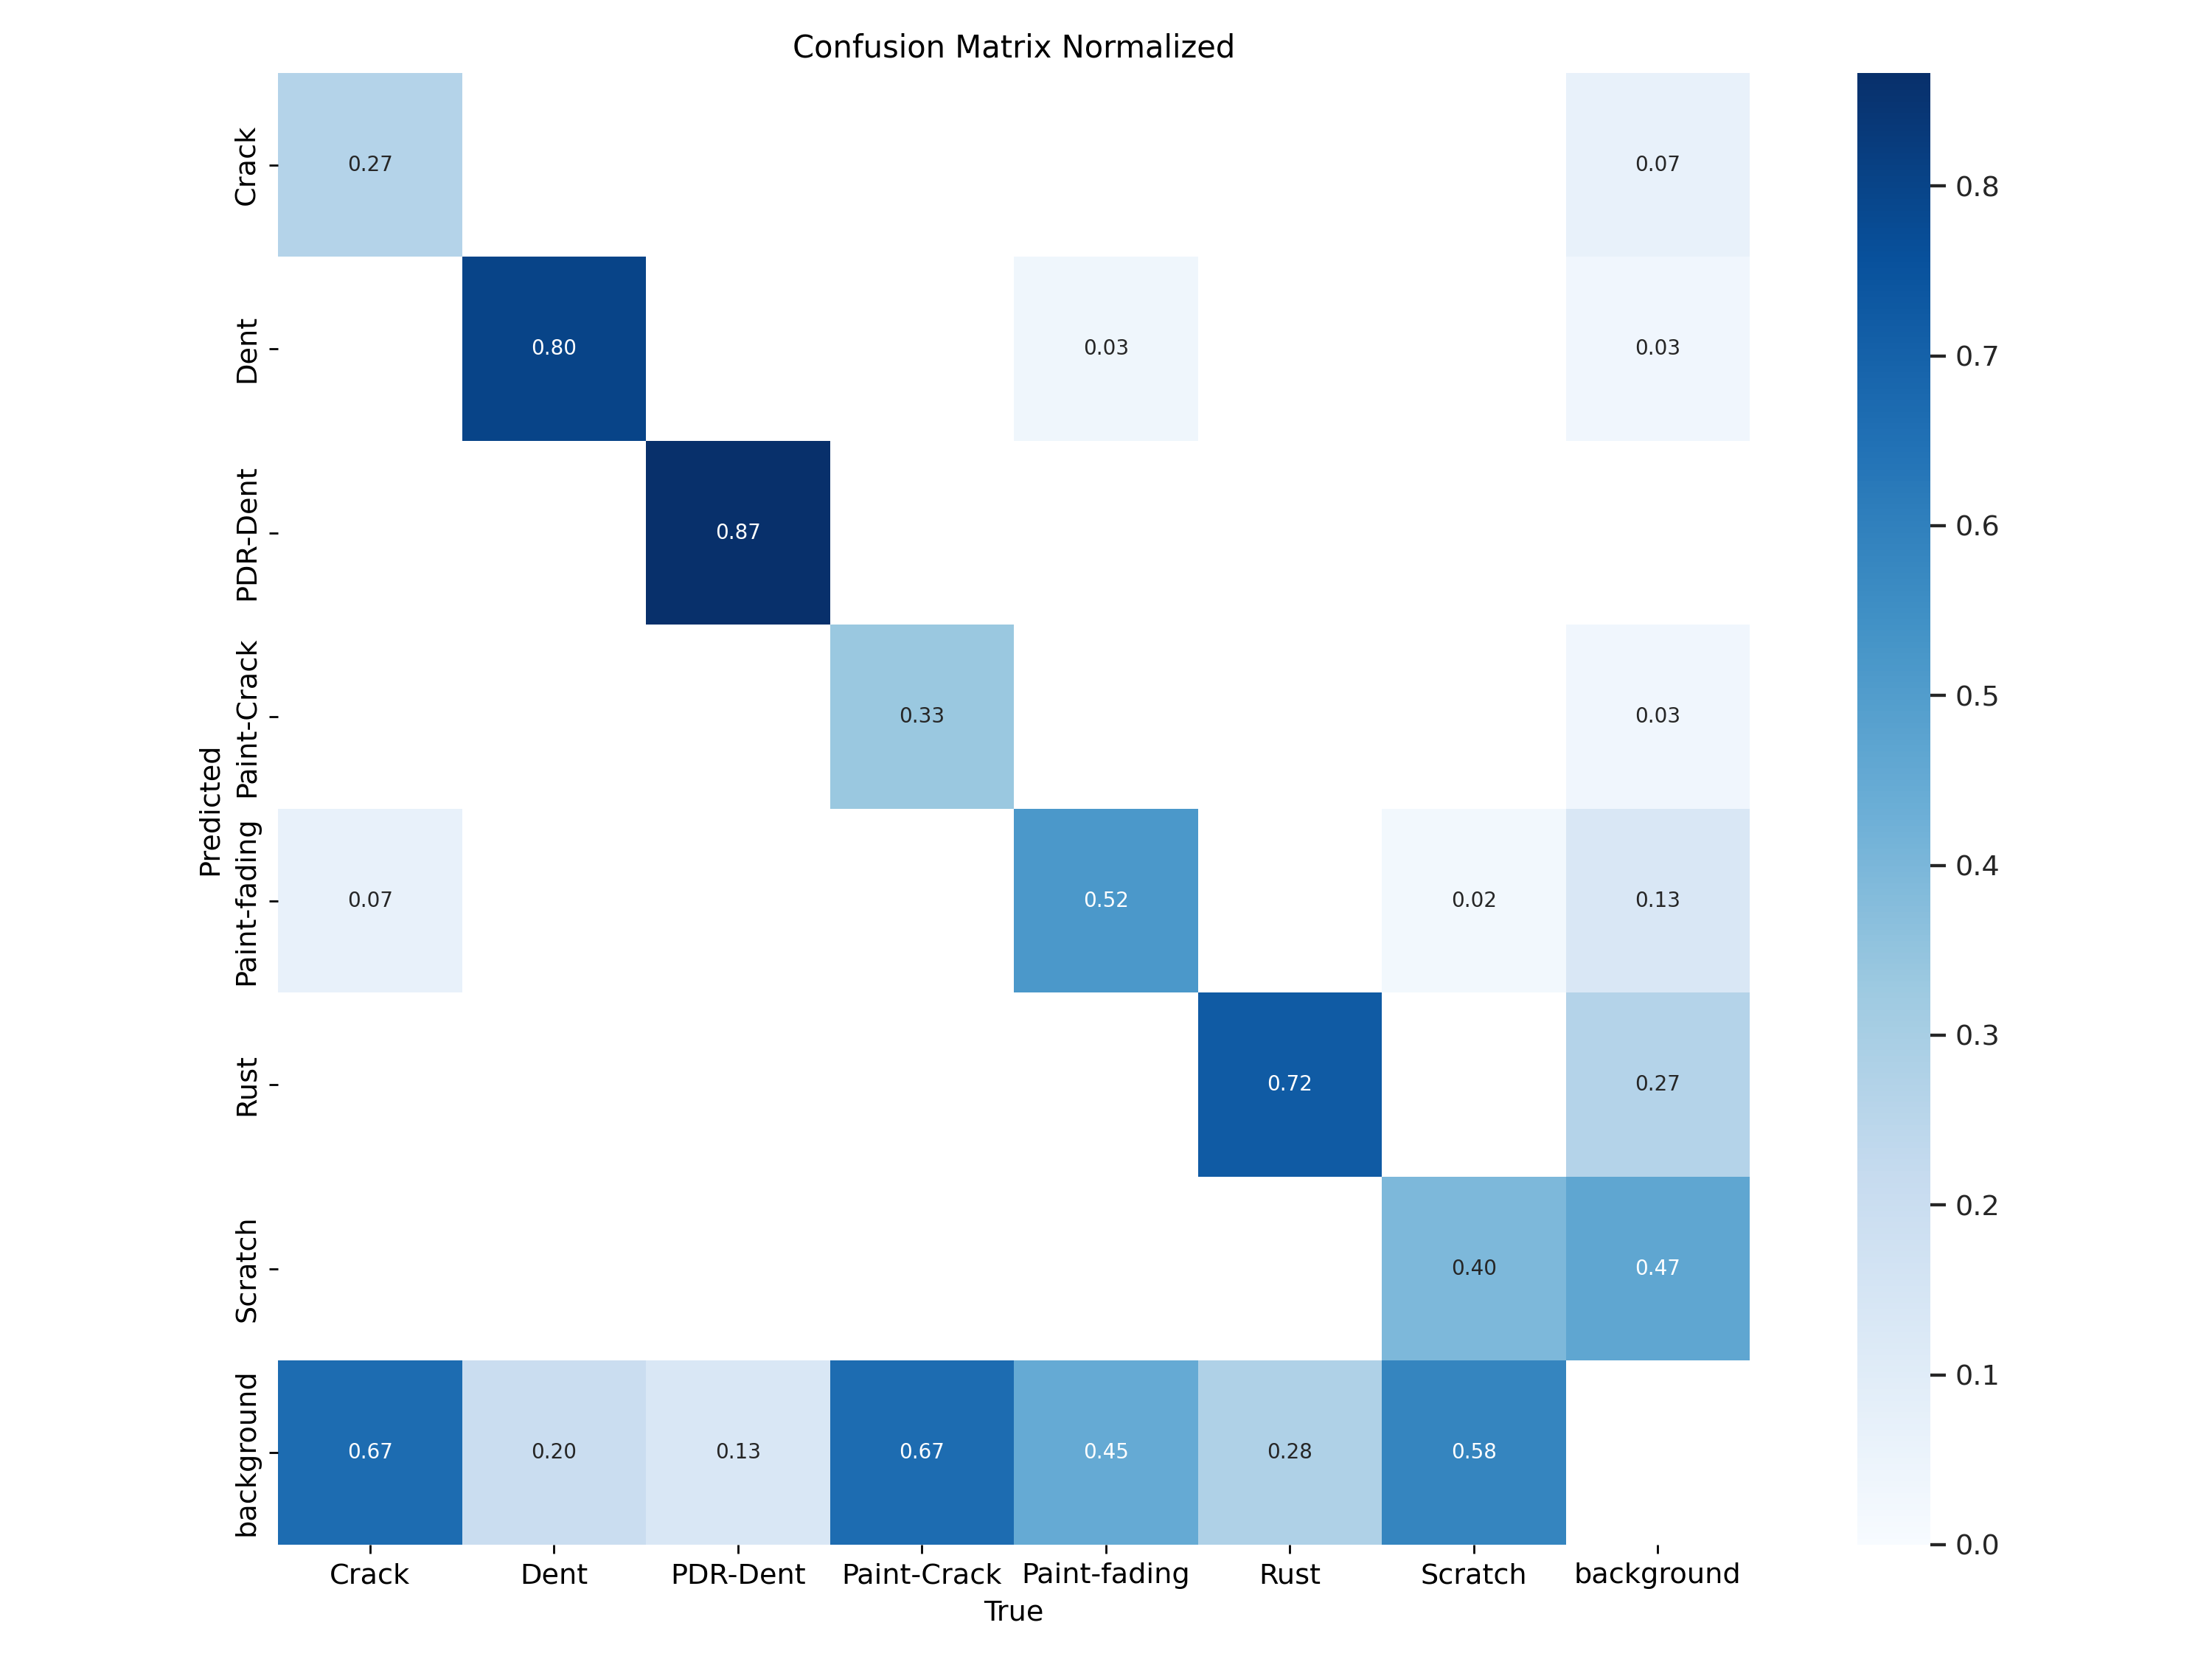

In [ ]:
# Display confusion matrix image
display(Image(filename='/content/runs/detect/train/confusion_matrix_normalized.png'))

In [ ]:
# Evaluate the YOLOv8 model with specified parameters
!yolo val model='/content/runs/detect/train/weights/best.pt' data='/content/data.yaml' imgsz=640

Krzywe ewaluacji

In [ ]:
# Sample paths to four evaluation images
img_paths = [
    '/content/runs/detect/val/F1_curve.png',
    '/content/runs/detect/val/PR_curve.png',
    '/content/runs/detect/val/P_curve.png',
    '/content/runs/detect/val/R_curve.png'
]

# Create a subplot with 1 row and 4 columns
fig, axs = plt.subplots(1, 4, figsize=(20, 5))  # Adjust the figure size as needed

# Display each image in the subplot
for ax, img_path in zip(axs, img_paths):
    img = PILImage.open(img_path)
    ax.imshow(img)
    ax.axis('off')  # Turn off the axis for better readability
plt.show()

Macierz pomyłek

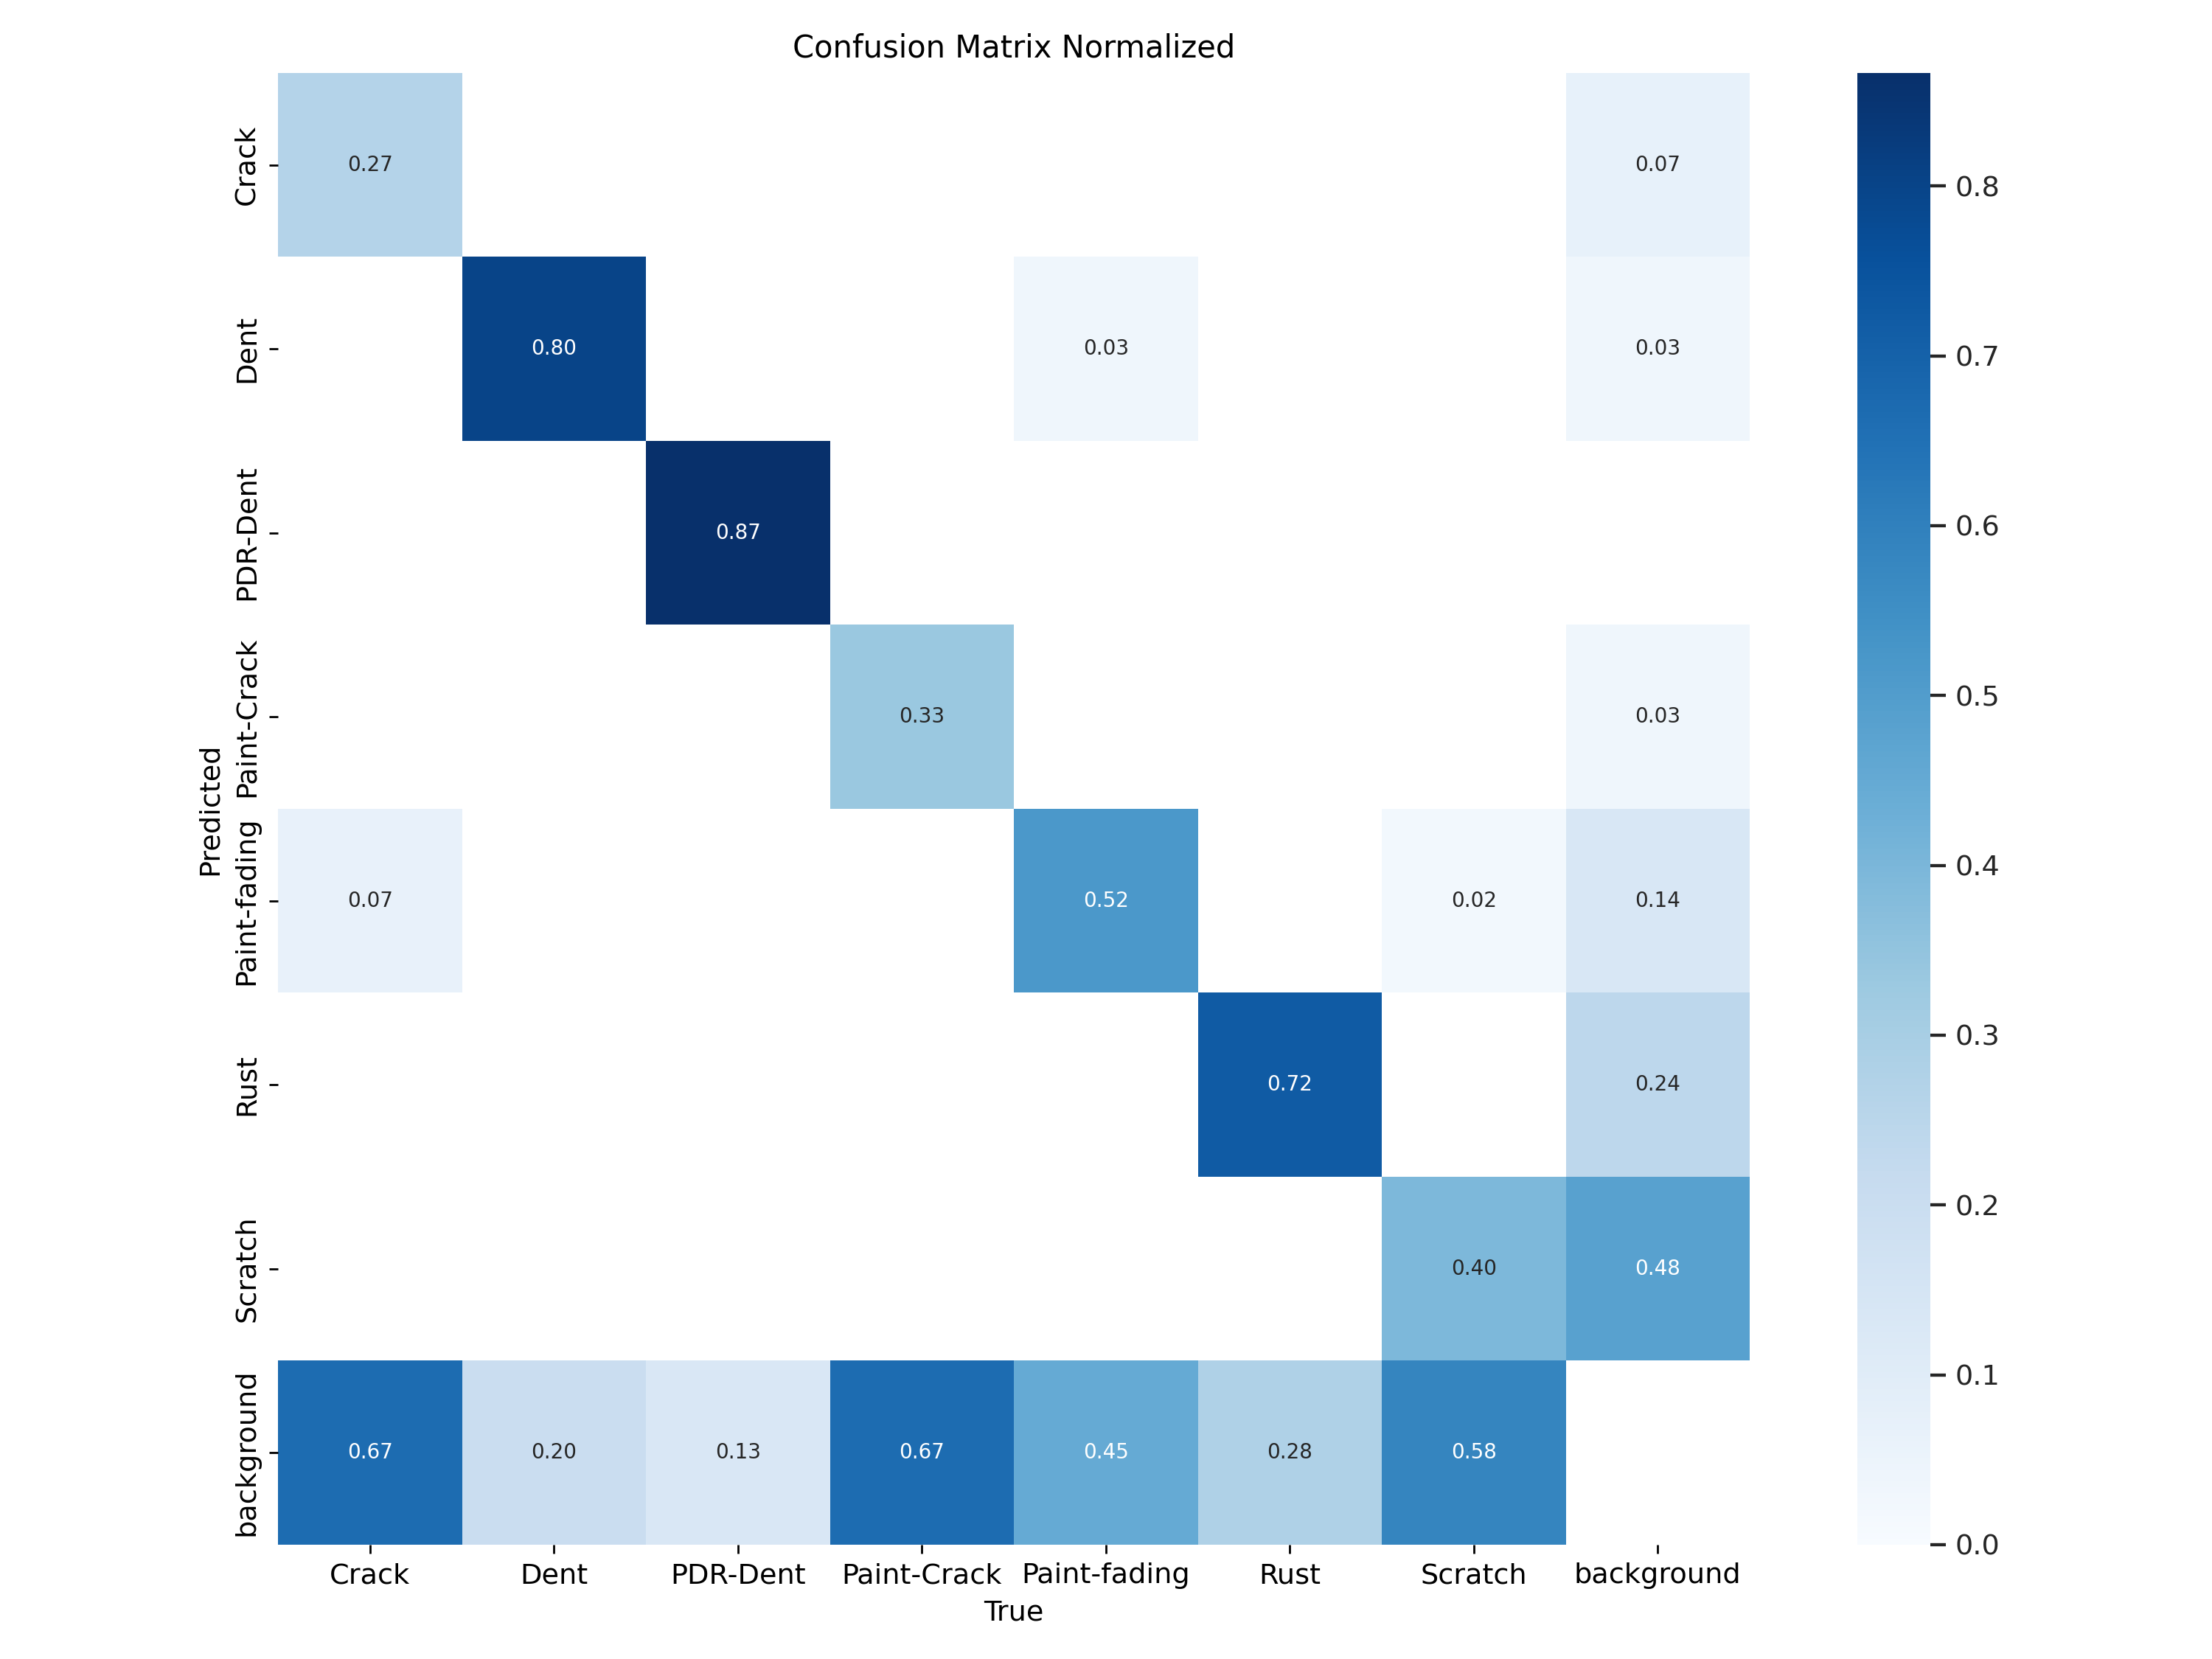

In [ ]:
# Display the confusion matrix image
display(Image(filename='/content/runs/detect/val/confusion_matrix_normalized.png'))

In [ ]:
# Load the model
model = YOLO('/content/runs/detect/train/weights/best.pt')

# Update the path to the test image directory
directory = data['test']

# Set the confidence threshold for predictions
confidence_threshold = 0.25

# Get a list of all the image files in the directory
image_files = [f for f in os.listdir(directory) if f.endswith('.jpg') or f.endswith('.png')]

# For each image file
for image_file in image_files:
    # Load the image
    img = cv2.imread(os.path.join(directory, image_file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

    # Predict the objects in the image
    results = model.predict(img)

    # Check if there are any results and process the first Results object
    if len(results) > 0:
        result = results[0]

        # Access the boxes attribute, ensure it is transferred to CPU and converted to numpy
        if hasattr(result, 'boxes') and result.boxes:
            detections = result.boxes.data.cpu().numpy()  # Transfer to CPU and convert to numpy

            # Iterate over each detection
            for detection in detections:
                conf = detection[4]  # Get the confidence score
                if conf > confidence_threshold:
                    x1, y1, x2, y2 = map(int, detection[:4])
                    label = result.names[int(detection[5])]

                    # Draw the bounding box and label on the image
                    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    cv2.putText(img, f"{label} {conf:.2f}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36, 255, 12), 2)

    # Show the image using matplotlib
    plt.figure(figsize=(12, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()


In [ ]:
# Zip the output directory
!zip -r /content/runs.zip ./runs


0: 480x640 1 Crack, 2 Paint-Cracks, 79.1ms
Speed: 3.5ms preprocess, 79.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


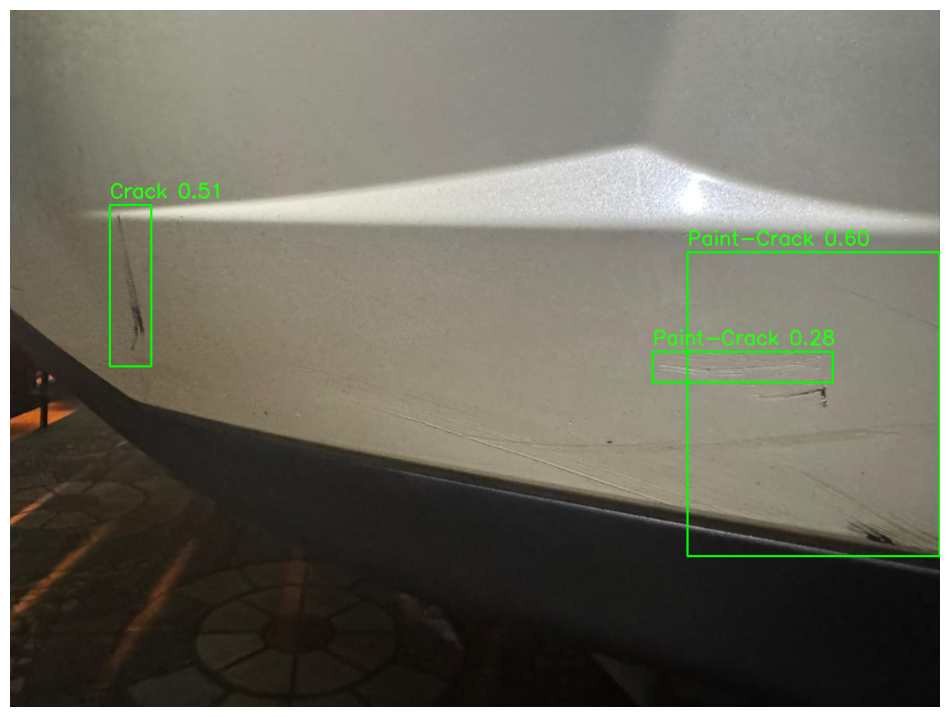

In [ ]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import torch

# Load the model
model = YOLO('/content/runs/detect/train/weights/best.pt')

# Path to the image
image_path = '/content/WhatsApp Image 2024-12-10 at 22.07.54_1c89d20b.jpg'  # Update with the path to your image

# Set the confidence threshold for predictions
confidence_threshold = 0.25

# Load the image
img = cv2.imread(image_path)
if img is None:
    raise FileNotFoundError(f"Image not found at {image_path}")

# Convert from BGR to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Predict the objects in the image
results = model.predict(img)

# Check if there are any results and process the first Results object
if len(results) > 0:
    result = results[0]

    # Access the boxes attribute, ensure it is transferred to CPU and converted to numpy
    if hasattr(result, 'boxes') and result.boxes:
        detections = result.boxes.data.cpu().numpy()  # Transfer to CPU and convert to numpy

        # Iterate over each detection
        for detection in detections:
            conf = detection[4]  # Get the confidence score
            if conf > confidence_threshold:
                x1, y1, x2, y2 = map(int, detection[:4])
                label = result.names[int(detection[5])]

                # Draw the bounding box and label on the image
                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(img, f"{label} {conf:.2f}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36, 255, 12), 2)

# Show the image using matplotlib
plt.figure(figsize=(12, 10))
plt.imshow(img)
plt.axis('off')
plt.show()
